# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Testing if cuda is on GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Spatial Data Generation


In [2]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 64
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y

In [12]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    #temp_path = video_list.loc[0]['path'] #da togliere!!!

    paths = []
    classes = []
    for index, row in video_list.iterrows(): #da togliere [:1]
        temp_path = row['path']                    #da rimuovere il commentato
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    return(list(zip(paths, classes)))

In [13]:
# ------- create train set
filenames = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
train_ds = configure_for_performance(ds)

In [14]:
frame_number_train = len(filenames)
print(frame_number_train)

60690


In [15]:
# ------- create val test
filenames = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
val_ds = configure_for_performance(ds)

In [16]:
frame_number_val = len(filenames)
print(frame_number_val)

26010


In [17]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)

948
406


# Spatial Stream Finetuned

In [50]:
checkpoint_filepath = './Models/spatial_model{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

## ResNet 1

In [51]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomCrop(img_height, img_width)
])

input = tf.keras.layers.Input(shape=(img_height, img_width, 3))

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_tensor=input,
                                                  pooling='avg',
                                                  weights='imagenet')
pretrained_model.trainable = False



resnet_model = Sequential()
data_augmentation

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

print(resnet_model.summary())

resnet_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 51)                26163     
                                                                 
Total params: 24,662,963
Trainable params: 1,075,251
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [52]:
history_ResNet1_spatial_stream = resnet_model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        epochs=1, 
                                        steps_per_epoch=step_per_epoch_train,
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

948/948 [==============================] - 530s 552ms/step - loss: 0.8065 - sparse_categorical_accuracy: 0.7843 - sparse_top_k_categorical_accuracy: 0.9301 - val_loss: 3.3858 - val_sparse_categorical_accuracy: 0.3196 - val_sparse_top_k_categorical_accuracy: 0.6477


In [ ]:
score = resnet_model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

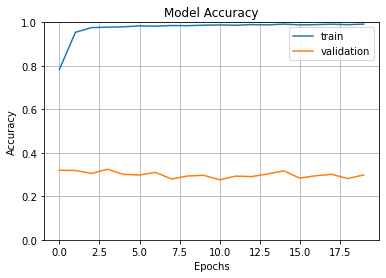

In [18]:
fig1 = plt.gcf()
plt.plot(history_ResNet1_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet1_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet1_0.png')
plt.show()

## ResNet 2

In [19]:
def build_model(num_classes, img_size=224):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="ResNet")
    #model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])
    model.compile(optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])
                    
    return model 

model = build_model(num_classes)
print(model.summary())

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [11]:
history_ResNet2_spatial_stream = model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        batch_size=batch_size, 
                                        epochs=5, 
                                        steps_per_epoch=step_per_epoch_train, 
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gianl\AppData\Local\Temp/ipykernel_3268/3751188769.py", line 1, in <module>
      history_ResNet2_spatial_stream = model.fit(train_ds,
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gianl\AppData\Local\Temp/ipykernel_3268/3751188769.py", line 1, in <module>
      history_ResNet2_spatial_stream = model.fit(train_ds,
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [240,320,3] and element 12 had shape [240,352,3].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 0. First element had shape [240,320,3] and element 12 had shape [240,352,3].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8957]

In [36]:
score = model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

406/406 [==============================] - 125s 308ms/step - loss: 2.7244 - sparse_categorical_accuracy: 0.3468 - sparse_top_k_categorical_accuracy: 0.6810
Loss val: 2.724404811859131
Sparse_categorical_accuracy: 0.3467518389225006
Sparse_top_5_categorical_accuracy: 0.681034505367279


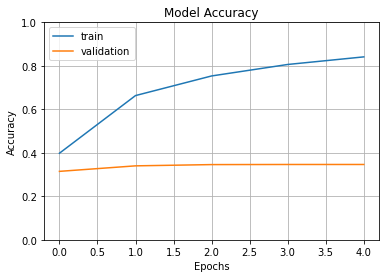

In [38]:
fig2 = plt.gcf()
plt.plot(history_ResNet2_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet2_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet2_1.png')
plt.show()

# Individual video prediction

In [41]:
# Opens the Video file 1

img_path = "C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2.mp4"
cap= cv2.VideoCapture(img_path)
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(f'C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2\\frame_{i}.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

In [42]:
# Opens the Video file 2

img_path = "C:\\Users\\gianl\\Desktop\\VID_20220830_115837_2.mp4"
cap= cv2.VideoCapture(img_path)
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(f'C:\\Users\\gianl\\Desktop\\VID_20220830_115837_2\\frame_{i}.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

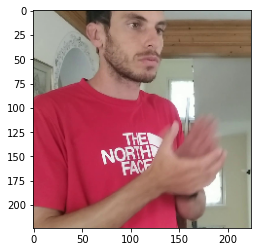

In [70]:
from tensorflow.keras.preprocessing import image


img = image.load_img('C:\\Users\\gianl\\Desktop\\VID_20220830_115011_2\\frame_7.jpg', target_size=(224, 224))

plt.imshow(img)
plt.show()


#model.predict_classes()

In [71]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [72]:
prediction = resnet_model.predict(img_preprocessed)
print(prediction[0])

1/1 [==============================] - 0s 29ms/step
[2.8946943e-07 1.0639540e-06 8.4375847e-07 4.3197409e-03 3.5396323e-03
 2.8742625e-06 6.4544133e-07 3.0987962e-07 3.0173145e-05 2.1314591e-08
 8.1420268e-07 6.5315058e-03 2.3108754e-05 3.5135251e-06 3.0266895e-07
 3.2631171e-09 8.3076393e-06 4.8779651e-07 3.4638746e-05 5.5884078e-07
 4.4951707e-04 2.1273074e-05 2.2992661e-07 4.9126902e-05 1.7046536e-06
 1.2689905e-04 5.6565023e-06 2.3544665e-06 2.7260205e-05 8.1497251e-07
 6.4619726e-10 5.7964709e-08 1.4941985e-04 3.8352857e-05 1.0103842e-04
 4.1339423e-05 6.8128654e-03 1.0129767e-04 6.4795582e-05 4.7870152e-02
 9.2822212e-01 2.3605637e-06 9.2902919e-06 8.7427406e-06 1.0413225e-06
 3.2109745e-07 1.6377772e-06 1.2706132e-03 3.7058584e-08 5.9566126e-05
 6.1172250e-05]


<BarContainer object of 51 artists>

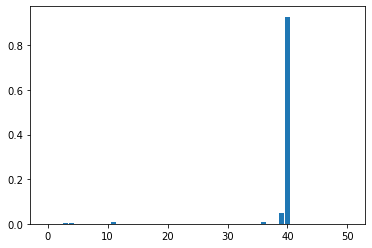

In [73]:
plt.bar(list(range(0,51)), prediction[0])